## Explanatory Notebook for random data generation used for the training of a CNN for digit recognition in a sudoku grid:
<br>
<br>

In [1]:
from __future__ import print_function
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import glob
from scipy import ndimage, misc
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix


import itertools

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Create a cell with a digit in the center:

First we create a plain image with random light background
the insert a random digit in it and then we create some the lines around the cell.


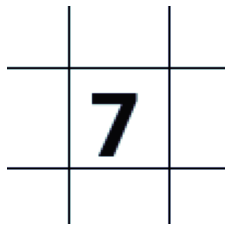

In [3]:

strip_width, strip_height = 100, 100

background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(80, 255), np.random.randint(80, 255), np.random.randint(80, 255)))

#font1 = ImageFont.truetype('/Library/Fonts/Arial.ttf', 40)
y=np.random.randint(0, 9+1) #Digit to write
y=7 # For this exemple we take 7
list_of_font=glob.glob('font2/*.ttf')
if y>0:
    text=str(y)
    #font = ImageFont.truetype('arial.ttf', 40)
    ff1=list_of_font[26]
    #print(ff1)
    font = ImageFont.truetype(ff1, 40)
    draw = ImageDraw.Draw(background)

    text_width, text_height = draw.textsize(text, font)
    
    position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
    color=(np.random.randint(0, 10), np.random.randint(0, 10), np.random.randint(0, 10))
    draw.text(position, text, color, font=font)
    #draw.text(position, str(y), color, font=font)
    

img=np.array(background)
#test_img=img
img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
img[:, [28, 74]]=1
img[[28, 74], :]=1
test_img=img #Save the test image for further use.

plt.imshow(img, cmap='bone')
plt.axis('off')
plt.show()



## Next we want to select random area of same size around the digit to account for imprecise cell separation in the algorithm

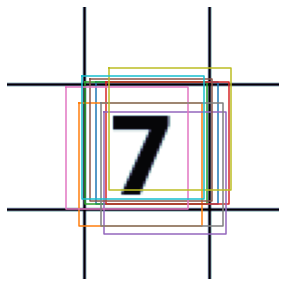

In [4]:
cell_size=45 #size of the cell we want to select
plt.figure(figsize=(5,5)) 
for i in range(0, 10):
    x=np.random.randint(19, 40) #to change.......
    y=np.random.randint(19, 40)
    x2=[x, x+cell_size, x+cell_size, x, x]
    y2=[y, y, y+cell_size, y+cell_size, y]
    plt.plot(x2, y2)

plt.imshow(img, cmap='bone')
plt.savefig('plots/cell_selection.png')
plt.axis('off')
plt.show()

## Add noise and elastic deformation:

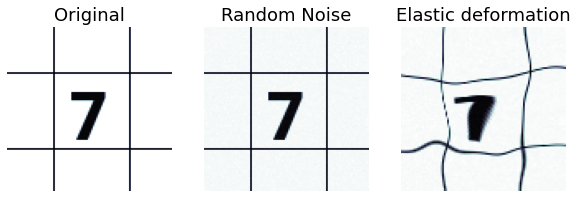

In [5]:
#from scipy.ndimage.interpolation import map_coordinates
#from scipy.ndimage.filters import gaussian_filter

def add_noise(img):
    row, col=np.shape(img)
    #mean = np.random.randint(0, 10)
    mean=10
    var = np.random.randint(1, 2)
    #print(var)
    #print(mean)
    sigma = var**0.01
    sigma = var**.1
    gauss = np.array((row, col))
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy.astype('uint8')

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)


img2=add_noise(img)
#img2=img
img3=elastic_transform(img2, 200, 10)

f = plt.figure(figsize=(10,20))
f.add_subplot(1,3, 1)
plt.imshow(img, cmap='bone')
plt.title('Original',fontsize=18)
plt.axis('off')
f.add_subplot(1,3, 2)
plt.imshow(img2, cmap='bone')
plt.title('Random Noise',fontsize=18)
plt.axis('off')

f.add_subplot(1,3, 3)
plt.imshow(img3, cmap='bone')
plt.title('Elastic deformation',fontsize=18)
#plt.show(block=True)
plt.axis('off')
plt.savefig('plots/noisy_images.png', bbox_inches='tight')
plt.show()

## All script:

<br>
for the (synthetic) training dataset, we added rotation between 10° and -10 °.
The data was also created as to reflect "real life" unbalance meaning that a lot more "0" are present on a grid than "true" digits. 



In [6]:

def rotate_img(img): #Rotate image with random angle between 0 and 10 degrees, fill unasigned corners with random [0.6-1]
    from scipy import ndimage, misc
    angle=np.random.randint(0, 20)-10
    random_background=np.random.randint(150, 255)
    img_rot = ndimage.rotate(img, angle, reshape=False, cval=random_background)
    return img_rot

def elastic_transform(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

    
def add_noise(img):
    row, col=np.shape(img)
    mean = np.random.randint(0, 10)
    var = np.random.randint(1, 2)
    #print(var)
    #print(mean)
    sigma = var**0.01
    gauss = np.array((row, col))
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = img + gauss
    return noisy.astype('uint8')

def get_image_part(img, cell_size):
    x=np.random.randint(12, 46)
    y=np.random.randint(12, 46)
    img=img[x:x+cell_size, y:y+cell_size]
    return img


def create_data(length, list_of_font, threshold=True, consider_empty=True):
    cell_size=45
    y_label=np.zeros(length, dtype=int)
    
    x_img=np.zeros((length, cell_size, cell_size), dtype=float)
    for i in range(0, length):
    
        
        if consider_empty:
            y=np.random.randint(-9, 9+1)
        
        else:
            y=np.random.randint(1, 9+1)
        
        if y<1:
            y_label[i]=0
            
        else:
            y_label[i]=y
            text=str(y)
        
        strip_width, strip_height = 100, 100

        background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(160, 255), np.random.randint(160, 255), np.random.randint(160, 255)))
        font1=list_of_font[np.random.randint(0, len(list_of_font))]
        #print(font1)
        
        font = ImageFont.truetype(font1, 40)
        draw = ImageDraw.Draw(background)
        
        
        if y>0:
            text=str(y)
            text_width, text_height = draw.textsize(text, font)
            position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
            color=(np.random.randint(0, 20), np.random.randint(0, 20), np.random.randint(0, 20))
            draw.text(position, str(y), color, font=font)
           
        img=np.array(background)
        img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
        bar_w=np.random.randint(1, 4)
        img[:, 28:28+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[:, 74:74+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[28:28+bar_w, :]=1
        bar_w=np.random.randint(1, 4)
        img[74:74+bar_w, :]=1
        img=get_image_part(img, cell_size)
        img=rotate_img(img) #randomly rotate image
        
        img=add_noise(img)
        lst_radius=[3, 5, 7, 9, 11, 13]
        radii=lst_radius[np.random.randint(0, 5)]
        
        img = cv2.GaussianBlur(img, (radii, radii), 0)#
        img=elastic_transform(img, np.random.randint(0, 80), np.random.randint(5, 10), random_state=None)
                
        x_img[i, :, :]=img
    return x_img, y_label
        
        
#list_of_font=['arial.ttf', 'Courier New.ttf', 'Times New Roman.ttf']
list_of_font=glob.glob('font2/*.ttf')


n=60000 #Number of image to generate
#n=50
xx, yy=create_data(n, list_of_font, False)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.33, random_state=42)

<br>

## Plot results of data Generation:

<br>
<br>

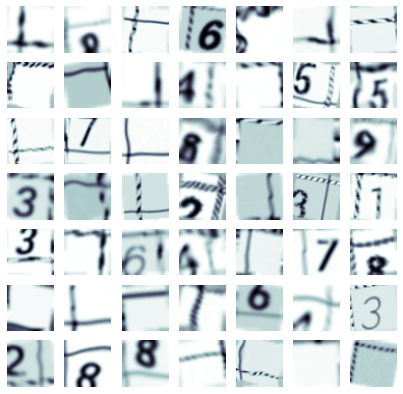

In [7]:
f = plt.figure(figsize=(7,7))

num_img=49
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(xx[i, :, :], cmap='bone')
    plt.axis('off')

plt.savefig('plots/digits1.png' , bbox_inches='tight')
plt.show()

## Train the Network:
<br>
<br>
Model building and training:
<br>


In [24]:

#validation Data:
y_test_path='data_npy/tot_labels43.npy'
x_test_path='data_npy/tot_img43.npy'
yy_lab=np.load(y_test_path)
y_test=np.array(yy_lab)
x_test=np.load(x_test_path)

num_classes=10
#y_test = keras.utils.to_categorical(yy_lab, num_classes)
x_train=xx
y_train=yy
print(np.shape(x_train))
x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))


(30000, 45, 45)
(30000, 45, 45, 1)
3483


In [15]:


#x_train, x_test, y_train, y_test = train_test_split(xx, yy, test_size=0.1)

cell_size=45
batch_size = 128
num_classes = len(np.unique(yy))
epochs = 60

# input image dimensions
img_rows, img_cols = cell_size, cell_size


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
####x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = Sequential()
model.add(Conv2D(32, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)


model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])


history_train=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 45, 45, 1)
60000 train samples
3483 test samples
Epoch 1/60
469/469 [==============================] - 17s 35ms/step - loss: 1.3225 - accuracy: 0.5574 - val_loss: 1.2778 - val_accuracy: 0.5923
Epoch 2/60
469/469 [==============================] - 4s 9ms/step - loss: 1.0778 - accuracy: 0.6055 - val_loss: 3.6386 - val_accuracy: 0.0551
Epoch 3/60
469/469 [==============================] - 4s 9ms/step - loss: 0.9734 - accuracy: 0.6413 - val_loss: 2.3931 - val_accuracy: 0.4025
Epoch 4/60
469/469 [==============================] - 4s 9ms/step - loss: 0.8627 - accuracy: 0.6864 - val_loss: 2.1929 - val_accuracy: 0.4855
Epoch 5/60
469/469 [==============================] - 4s 9ms/step - loss: 0.7534 - accuracy: 0.7330 - val_loss: 1.6383 - val_accuracy: 0.5975
Epoch 6/60
469/469 [==============================] - 4s 10ms/step - loss: 0.6399 - accuracy: 0.7769 - val_loss: 1.4386 - val_accuracy: 0.6566
Epoch 7/60
469/469 [==============================] - 4s 9ms/step - loss:

Epoch 58/60
469/469 [==============================] - 4s 9ms/step - loss: 0.0817 - accuracy: 0.9741 - val_loss: 0.1552 - val_accuracy: 0.9759
Epoch 59/60
469/469 [==============================] - 4s 9ms/step - loss: 0.0858 - accuracy: 0.9728 - val_loss: 0.1699 - val_accuracy: 0.9733
Epoch 60/60
469/469 [==============================] - 4s 9ms/step - loss: 0.0833 - accuracy: 0.9745 - val_loss: 0.1808 - val_accuracy: 0.9796
Test loss: 0.18077883124351501
Test accuracy: 0.9796152710914612


## Plot the training and testing loss and accuracy:

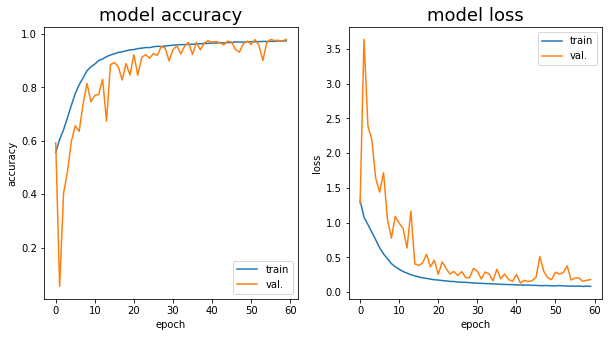

In [16]:

f = plt.figure(figsize=(10,5))
f.add_subplot(1,2, 1)
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='lower right')

f.add_subplot(1,2, 2)
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss',fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper right')
plt.savefig('plots/training_stats1.png' , bbox_inches='tight')

plt.show()



# Save model for further use:

In [17]:
model.save("models/digit_recognition_model_x1.h5")

## Validation set from real sudoku grids:

<br>
<br>

Here we try to access how robust our model is in recognising cell images extracted from several real sudoku  grids. The sudoku images we used are available in the  sample_img  folder and the cell areas have been extracted following the process shown on the sgrid_detection.ipynb Notebook.

<br>


In [18]:
#Load data from real sudoku grids:

yy_lab=np.load(y_test_path)
yy_lab=np.array(yy_lab)
raw_img=np.load(x_test_path)
xx_1=raw_img

In [19]:
y_x = tf.keras.utils.to_categorical(yy_lab, num_classes)
#Returns the loss value & metrics values for the model in test mode.
lo, acc=model.evaluate(xx_1, y_x, batch_size=81)
print('accuracy: ', round(acc, 4))

43/43 [==============================] - 0s 3ms/step - loss: 0.1808 - accuracy: 0.9796
accuracy:  0.9796


The model is performing not too bad but we can do even better by in the training data as we will see...

In [20]:
pred=model.predict(x_test)
y_pred=pred.argmax(1)
print(y_pred)

[0 0 0 ... 0 0 0]


## Confusion Matrix:

<br>
<br>

In [21]:

matrix = confusion_matrix(yy_lab, y_pred)
print(matrix)


[[2297    2    0    1    2    5    0    0    0    0]
 [   0  124    0    0    0    0    0    0    0    0]
 [   0    1  125    8    0    0    0    0    0    0]
 [   1    3    0  134    0    1    0    0    0    0]
 [   0    5    0    0  112    0    6    0    0    0]
 [   0    1    0    0    0  147    0    0    0    0]
 [   1    0    0    0    0    3  115    0    1    2]
 [   0   12    0    1    0    0    0  128    0    0]
 [   0    0    0    0    1    1    0    0  124   11]
 [   0    2    0    0    0    0    0    0    0  106]]


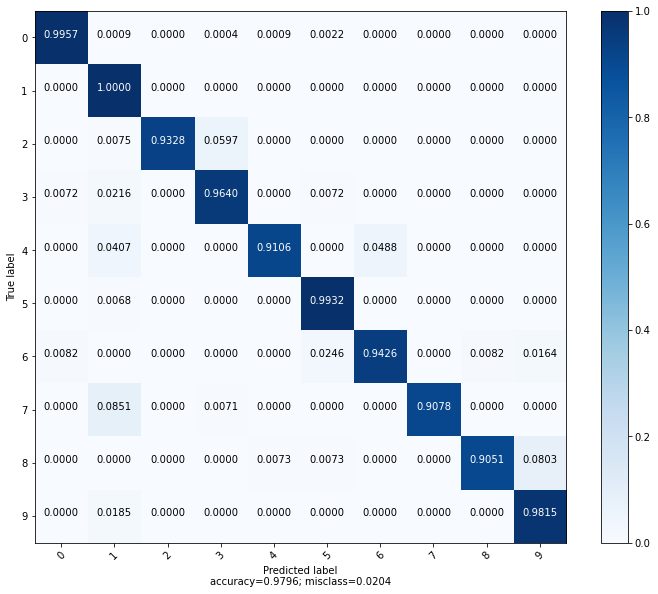

In [22]:
#Normalized Confusion Matrix:

cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]


cm=matrix
normalize=True
target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

cmap=None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#plt.title(title)
plt.colorbar()

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('plots/conf_matrix_first_training.png' , bbox_inches='tight')
plt.show()

<br>

## Display failed recogntions:

<br>
<br>

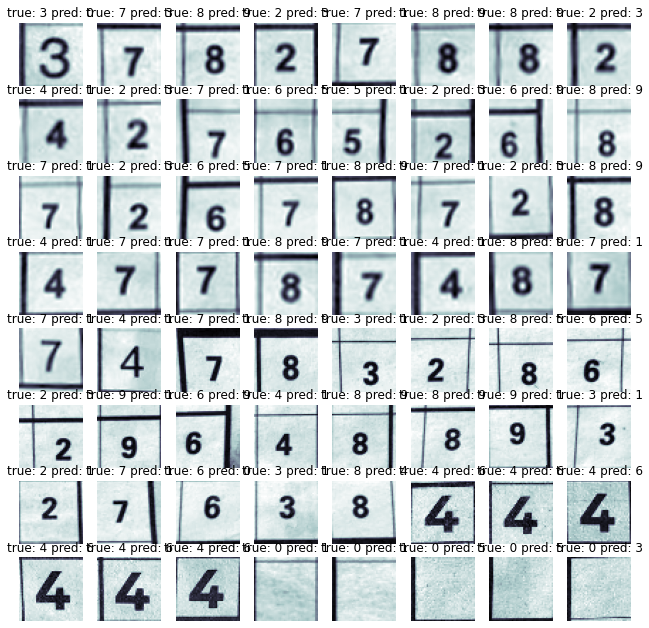

71


In [23]:
k=0
cell_size=45
true=[]
predicted=[]
j=0
gr_t=1
grid=[]
lst_index=[]
for i in range(0, len(y_pred)):
    if y_pred[i]!= yy_lab[i]:
        k=k+1
        lst_index.append(i)
        true.append(yy_lab[i])
        predicted.append(y_pred[i])
        #print(yy_lab[i])
        if j>80:
            gr_t=gr_t+1
            j=0
        grid.append(gr_t)
        
    
    j=j+1
        
        
        

failed=np.zeros((k, cell_size, cell_size), dtype=float)

for i in range(0, len(lst_index)):
    img=x_test[lst_index[i], :, :, 0]
    failed[i, :, :]=img
    #true.append(yy_lab[lst_index[i]])
    #predicted.append(y_pred[lst_index[i]])


num_img=64
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


f = plt.figure(figsize=(11,11))
for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(failed[i, :, :], cmap='bone')
    #tt='pred: '+str(predicted[i])
    tt='true: '+str(true[i])+' pred: '+str(predicted[i])
    plt.title(tt,fontsize=12)
    plt.axis('off')

plt.savefig('plots/failed_digitsx.png' , bbox_inches='tight')
plt.show()
print(k)

We can see that our trained model fails to recognize images with digits of differents sizes.
<br>
We will habe to add some variation in the digit size to the training set.
<br>
The failed recognitions also have local noise probably type salt and pepper and Perlin noise.
<br>
This ispossibly due to change in light exposure when the picture was taken or the quality of the camera.
<br>
Indeed if we use adaptative threshold on those images:
<br>

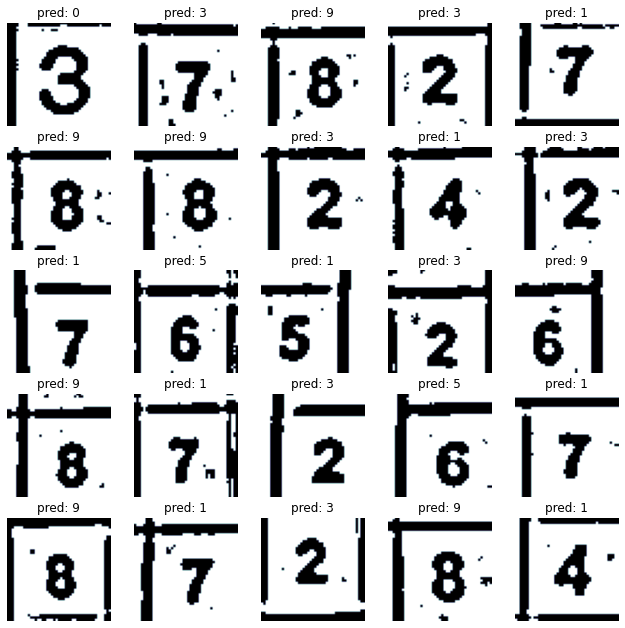

In [24]:
num_img=25
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))

f = plt.figure(figsize=(11,11))
for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    img=failed[i, :, :]*255
   
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(img, kernel, iterations = 1)
    dilation = cv2.dilate(erosion, kernel, iterations = 1)
    #img2=np.expand_dims(dilation, axis=-1)
    #img2=np.expand_dims(img2, axis=0)
    #pred2=model.predict(img2)
    #y_pred=pred2.argmax(1)
    #print(y_pred, true[i])
    
    img = cv2.blur(img,(5, 5), 0).astype('uint8')
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    plt.imshow(thresh, cmap='bone')
    tt='pred: '+str(predicted[i])
    #tt='true: '+str(true[i])+' pred: '+str(predicted[i])
    plt.title(tt,fontsize=12)
    plt.axis('off')

plt.savefig('plots/failed_digits1_tresh.png' , bbox_inches='tight')
plt.show()

## Add Perlin Noise: 

We can see some patch of noise in the image which could be responsible for fooling the algorithm.
<br>
Basically there are two diffrent approach to solve this issue: 
<br>
* Either we increase the preprosessing step in the extracted images in order to eliminate this noise before analysis.
<br>
* Or we reproduce this kind of noise for the training data.
<br>
The first approach would require some simple morphological operation such as errosion and dilatation but here we would like to increase our neural network performance so let's focus on the second aproach.
To achieve this we will try to add localized perturbation to our training images, the kind of disturbances we will try are called Perlin noise and salt and Pepper:
<br>


/home/simon/anaconda3/envs/simenv/lib/python3.7/site-packages/ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


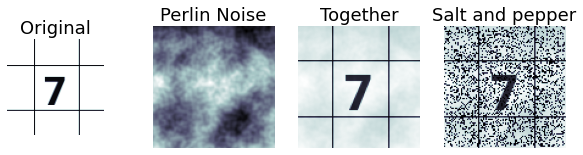

In [25]:
import noise # New package needed for perlin noise.

def test_perlin_noise(img):
    shape = np.shape(img)[0], np.shape(img)[1]
    scale=900
    octaves=6
 
    persistence=0.5
    lacunarity=30
    lacunarity=3
    noisy = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noisy[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)
    noisy=noisy*250
    img2=img+noisy
    img2=np.minimum(255, img2)
    img2=np.maximum(0, img2)
    return img2, noisy




def salt_pepper(image):
    
    row,col = image.shape
    s_vs_p = 0.5
    amount = 0.3
    out = np.copy(image)
        # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    #out[coords] = 1
    out[tuple(coords)] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    #out[coords] = 0
    out[tuple(coords)] =0
    return out


im1, im2=test_perlin_noise(test_img)
im3=salt_pepper(im1)

#plt.imshow(test_img)
#plt.show()
f = plt.figure(figsize=(10,20))
f.add_subplot(1,5, 1)
plt.imshow(test_img, cmap='bone')
plt.title('Original',fontsize=18)
plt.axis('off')
f.add_subplot(1,4, 2)
plt.imshow(im2, cmap='bone')
plt.title('Perlin Noise',fontsize=18)
plt.axis('off')

f.add_subplot(1,4, 3)
plt.imshow(im1, cmap='bone')
plt.title('Together',fontsize=18)
#plt.show(block=True)
plt.axis('off')
#plt.savefig('noisy_images.png', bbox_inches='tight')

f.add_subplot(1,4, 3)
plt.imshow(im1, cmap='bone')
plt.title('Together',fontsize=18)
#plt.show(block=True)
plt.axis('off')
#plt.savefig('noisy_images.png', bbox_inches='tight')


f.add_subplot(1,4, 4)
plt.imshow(im3, cmap='bone')
plt.title('Salt and pepper',fontsize=18)
#plt.show(block=True)
plt.axis('off')
plt.savefig('plots/added_noise2.png' , bbox_inches='tight')
plt.show()






And if we wrap this up with everything we have used befor for our training data generation:

<br>
Note that we also corrected the data imbalance closer to the true representation (around 70% of empty cells)
<br>

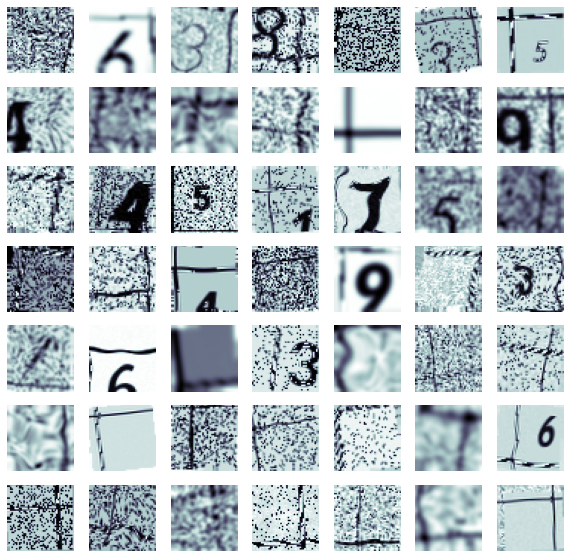

In [27]:
import noise

def perlin_noise(img):
 
    shape = np.shape(img)[0], np.shape(img)[1]
    scale = np.random.randint(1, 1500)
    
    octaves=np.random.randint(4, 15)
   
 
    persistence=np.random.random_sample()*25
    #persistence=np.random.randint(1, 20)
    #lacunarity = 1.0
    #lacunarity=100
    lacunarity=(np.random.random_sample()+0.2)*100

    noisy = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noisy[i][j] = noise.pnoise2(i/scale, 
                                    j/scale, 
                                    octaves=octaves, 
                                    persistence=persistence, 
                                    lacunarity=lacunarity, 
                                    repeatx=1024, 
                                    repeaty=1024, 
                                    base=0)
    noisy=noisy*255
    img2=img+noisy
    
    img2=np.minimum(255, img2)
    img2=np.maximum(0, img2)
    #print(np.max(img2))
    #print(np.min(img2))
    return img2




def salt_pepper(image):
    
    row,col = image.shape
    s_vs_p = np.random.randint(0, 9)/10
    amount = np.random.randint(0, 5)/10
    out = np.copy(image)
        # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    #out[coords] = 1
    out[tuple(coords)] = np.random.randint(0, 10)/10

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    #out[coords] = 0
    out[tuple(coords)] =np.random.randint(0, 10)/10
    return out


def create_data2(length, list_of_font, threshold=True, consider_empty=True):
    cell_size=45
    y_label=np.zeros(length, dtype=int)
    
    x_img=np.zeros((length, cell_size, cell_size), dtype=float)
    for i in range(0, length):
    
        
        if consider_empty:
            y=np.random.randint(-20, 9+1)
        
        else:
            y=np.random.randint(1, 9+1)
        
        if y<1:
            y_label[i]=0
            
        else:
            y_label[i]=y
            text=str(y)
        
        strip_width, strip_height = 100, 100

        background =Image.new('RGB', (strip_width, strip_height), color = (np.random.randint(160, 255), np.random.randint(160, 255), np.random.randint(160, 255)))
        font1=list_of_font[np.random.randint(0, len(list_of_font))]
        #print(font1)
        
        text_size=np.random.randint(18, 55)
        font = ImageFont.truetype(font1, text_size)
        draw = ImageDraw.Draw(background)
        
        
        if y>0:
            text=str(y)
            text_width, text_height = draw.textsize(text, font)
            position = ((strip_width-text_width)/2,(strip_height-text_height)/2)
            color=(np.random.randint(0, 20), np.random.randint(0, 20), np.random.randint(0, 20))
            draw.text(position, str(y), color, font=font)
           
        img=np.array(background)
        img=0.2989*img[:, :, 0]+0.5870*img[:, :, 1]+0.1140*img[:, :, 2]
        bar_w=np.random.randint(1, 4)
        img[:, 28:28+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[:, 74:74+bar_w]=1
        bar_w=np.random.randint(1, 4)
        img[28:28+bar_w, :]=1
        bar_w=np.random.randint(1, 4)
        img[74:74+bar_w, :]=1
        img=get_image_part(img, cell_size)
        img=rotate_img(img) #randomly rotate image
        
        img=add_noise(img)
        img=perlin_noise(img)
        img=salt_pepper(img)
        
        lst_radius=[3, 5, 7, 9, 11, 13]
        radii=lst_radius[np.random.randint(0, 5)]
        
        if np.random.random_sample()>0.6:
            img = cv2.GaussianBlur(img, (radii, radii), 0)
            
        img=elastic_transform(img, np.random.randint(0, 80), np.random.randint(5, 10), random_state=None)
                
        x_img[i, :, :]=img
        #plt.imshow(img, cmap='bone')
        #plt.show()
        
    return x_img, y_label


n=60000 #Number of image to generate
#n=60
list_of_font=glob.glob('font2/*.ttf')

xx, yy=create_data2(n, list_of_font, False)

f = plt.figure(figsize=(10,10))

num_img=49
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(xx[i, :, :], cmap='bone')
    plt.axis('off')

#plt.savefig('plots/digits4.png' , bbox_inches='tight')
plt.show()

In [29]:

#validation Data:


yy_lab=np.load(y_test_path)
y_test=np.array(yy_lab)
x_test=np.load(x_test_path)

num_classes=10
#y_test = keras.utils.to_categorical(yy_lab, num_classes)
x_train=xx
y_train=yy
print(np.shape(x_train))
x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))

(60000, 45, 45)
(60000, 45, 45, 1)
3483


In [30]:
cell_size=45
batch_size = 128
num_classes = len(np.unique(yy))
epochs = 25

# input image dimensions
img_rows, img_cols = cell_size, cell_size


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
####x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


model = Sequential()
model.add(Conv2D(32, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
#opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6)

opt=tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy']) # ! Unbalanced sample (more 0s)

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=opt,
#              metrics=['accuracy'])


history_train=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 45, 45, 1)
60000 train samples
3483 test samples
Epoch 1/25
469/469 [==============================] - 4s 9ms/step - loss: 0.9712 - accuracy: 0.7205 - val_loss: 0.5248 - val_accuracy: 0.8237
Epoch 2/25
469/469 [==============================] - 4s 9ms/step - loss: 0.7072 - accuracy: 0.7742 - val_loss: 0.3318 - val_accuracy: 0.8943
Epoch 3/25
469/469 [==============================] - 4s 9ms/step - loss: 0.5576 - accuracy: 0.8250 - val_loss: 0.1316 - val_accuracy: 0.9676
Epoch 4/25
469/469 [==============================] - 4s 9ms/step - loss: 0.4561 - accuracy: 0.8587 - val_loss: 0.0564 - val_accuracy: 0.9836
Epoch 5/25
469/469 [==============================] - 4s 9ms/step - loss: 0.3804 - accuracy: 0.8837 - val_loss: 0.0270 - val_accuracy: 0.9925
Epoch 6/25
469/469 [==============================] - 4s 9ms/step - loss: 0.3293 - accuracy: 0.9000 - val_loss: 0.0197 - val_accuracy: 0.9945
Epoch 7/25
469/469 [==============================] - 4s 9ms/step - loss: 0.

In [31]:
pred=model.predict(x_test)
y_pred=pred.argmax(1)
print(y_pred)

matrix = confusion_matrix(yy_lab, y_pred)

cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)
#print(cm_normalized )

[0 0 0 ... 0 0 0]
[[2305    0    0    0    2    0    0    0    0    0]
 [   0  124    0    0    0    0    0    0    0    0]
 [   0    0  134    0    0    0    0    0    0    0]
 [   0    0    0  139    0    0    0    0    0    0]
 [   0    0    0    0  123    0    0    0    0    0]
 [   0    0    0    0    0  147    1    0    0    0]
 [   0    0    0    0    0    0  121    0    1    0]
 [   0    0    0    0    0    0    0  141    0    0]
 [   0    0    0    0    0    0    0    0  137    0]
 [   0    0    0    0    0    0    0    0    1  107]]


In [32]:
model.save("models/digit_recognition_model9985.h5")

In [25]:
#Compare histogram density of training and test set

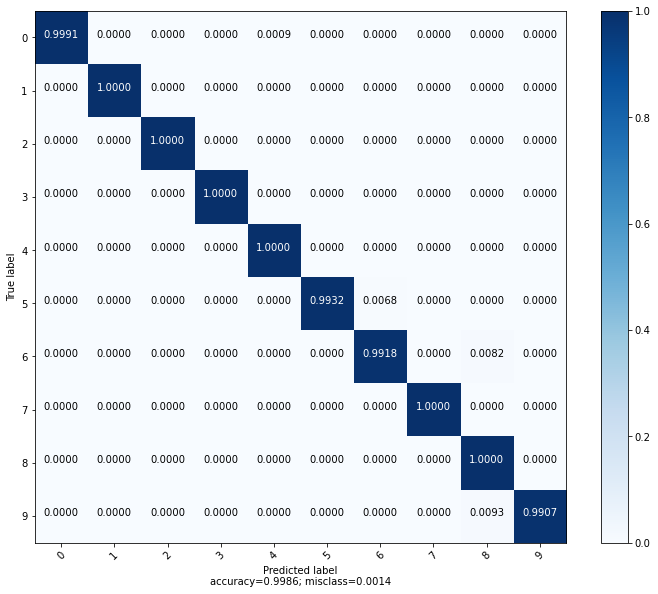

In [33]:

cm=matrix
normalize=True
target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


import matplotlib.pyplot as plt
import numpy as np
import itertools
cmap=None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#plt.title(title)
plt.colorbar()

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('plots/conf_matrix3.png' , bbox_inches='tight')
plt.show()

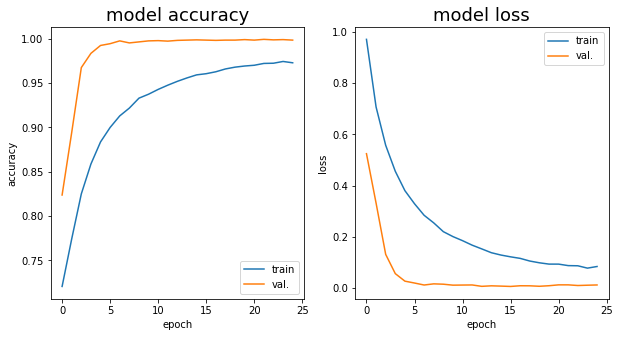

In [34]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2, 1)
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='lower right')

f.add_subplot(1,2, 2)
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss',fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper right')
plt.savefig('plots/training_stats2.png' , bbox_inches='tight')

plt.show()

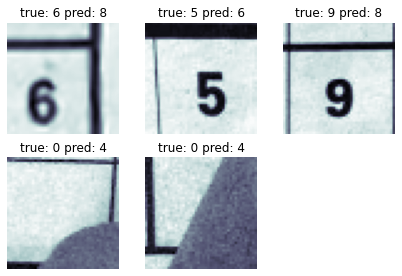

5


In [35]:
k=0
cell_size=45
true=[]
predicted=[]
j=0
gr_t=1
grid=[]
lst_index=[]
for i in range(0, len(y_pred)):
    if y_pred[i]!= yy_lab[i]:
        k=k+1
        lst_index.append(i)
        true.append(yy_lab[i])
        predicted.append(y_pred[i])
        #print(yy_lab[i])
        if j>80:
            gr_t=gr_t+1
            j=0
        grid.append(gr_t)
        
    
    j=j+1
        
        
        

failed=np.zeros((k, cell_size, cell_size), dtype=float)

for i in range(0, len(lst_index)):
    img=x_test[lst_index[i], :, :, 0]
    failed[i, :, :]=img
    #true.append(yy_lab[lst_index[i]])
    #predicted.append(y_pred[lst_index[i]])


num_img=k
#n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))
n, m=3, 3

f = plt.figure(figsize=(7,7))
for i in range(1, num_img+1):
    f.add_subplot(n,m, i)
    plt.imshow(failed[i-1, :, :], cmap='bone')
    #tt='pred: '+str(predicted[i])
    tt='true: '+str(true[i-1])+' pred: '+str(predicted[i-1])
    plt.title(tt,fontsize=12)
    plt.axis('off')

plt.savefig('plots/failed_digits2.png' , bbox_inches='tight')
plt.show()
print(k)

## Transfer Learning:
<br>

In this section we will try to increase our accuracy even further by using pre trained models.
<br>
Those Models have the advantages of having already learned the useful features for image recognition tasks
<br>
This also have the added benefit of deacreasing the training time.
<br>
<br>

In [36]:
#create new data

list_of_font=glob.glob('font2/*.ttf')
print(len(list_of_font))
xx, yy=create_data2(60000, list_of_font, False)



49


In [37]:
def increase_chanel(gray_array):
    new_array = np.repeat(gray_array[..., np.newaxis], 3, -1)
    return new_array


yy_lab=np.load(y_test_path)
y_test=np.array(yy_lab)
x_test=np.load(x_test_path)

num_classes=10
#y_test = keras.utils.to_categorical(yy_lab, num_classes)
x_train=xx
y_train=yy
print(np.shape(x_train))
#x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255

x_test=x_test[:, :, :, 0]
x_test=increase_chanel(x_test)
x_train=increase_chanel(x_train)

print(np.shape(x_train))
print(np.shape(x_test))

(60000, 45, 45)
(60000, 45, 45)
3483
(60000, 45, 45, 3)
(3483, 45, 45, 3)


In [38]:

#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Activation
#from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

inputShape=(45, 45, 3)
classes=10
#base_model = MobileNet(weights='imagenet', include_top=False, input_shape=inputShape)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=inputShape)
#base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=inputShape)



x = base_model.output

# define classification layers
x = Flatten()(x)
x = Dense(classes)(x)
preds = Activation("softmax")(x)

#
model = Model(inputs=base_model.input, outputs=preds)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 45, 45, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 45, 45, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 45, 45, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 22, 22, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 22, 22, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 22, 22, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 11, 11, 128)       0     

In [39]:



batch_size=100
epochs=20

opt=tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy']) # ! Unbalanced sample (more 0s)

#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=opt,
#              metrics=['accuracy'])


history_train=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
600/600 [==============================] - 41s 68ms/step - loss: 0.7517 - accuracy: 0.7567 - val_loss: 0.1591 - val_accuracy: 0.9543
Epoch 2/20
600/600 [==============================] - 23s 38ms/step - loss: 0.3263 - accuracy: 0.8946 - val_loss: 0.0072 - val_accuracy: 0.9980
Epoch 3/20
600/600 [==============================] - 23s 38ms/step - loss: 0.2181 - accuracy: 0.9397 - val_loss: 0.0132 - val_accuracy: 0.9968
Epoch 4/20
600/600 [==============================] - 23s 38ms/step - loss: 0.1694 - accuracy: 0.9541 - val_loss: 0.0048 - val_accuracy: 0.9977
Epoch 5/20
600/600 [==============================] - 23s 38ms/step - loss: 0.1470 - accuracy: 0.9607 - val_loss: 0.0092 - val_accuracy: 0.9980
Epoch 6/20
600/600 [==============================] - 23s 38ms/step - loss: 0.1372 - accuracy: 0.9641 - val_loss: 0.0033 - val_accuracy: 0.9997
Epoch 7/20
600/600 [==============================] - 23s 38ms/step - loss: 0.1216 - accuracy: 0.9674 - val_loss: 0.2044 - val_accuracy:

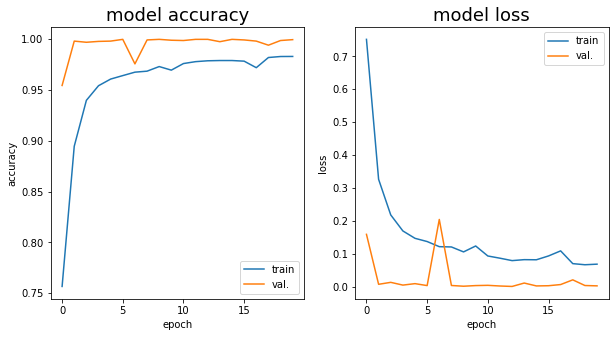

In [40]:
f = plt.figure(figsize=(10,5))
f.add_subplot(1,2, 1)
plt.plot(history_train.history['accuracy'])
plt.plot(history_train.history['val_accuracy'])
plt.title('model accuracy', fontsize=18)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='lower right')

f.add_subplot(1,2, 2)
plt.plot(history_train.history['loss'])
plt.plot(history_train.history['val_loss'])
plt.title('model loss',fontsize=18)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper right')
plt.savefig('plots/training_stats3.png' , bbox_inches='tight')

plt.show()

In [41]:
pred=model.predict(x_test)
y_pred=pred.argmax(1)
print(y_pred)

matrix = confusion_matrix(yy_lab, y_pred)

cm_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
print(matrix)
#print(cm_normalized )

[0 0 0 ... 0 0 0]
[[2306    0    0    0    0    0    0    1    0    0]
 [   0  124    0    0    0    0    0    0    0    0]
 [   0    0  134    0    0    0    0    0    0    0]
 [   0    0    0  139    0    0    0    0    0    0]
 [   0    0    0    0  122    1    0    0    0    0]
 [   0    0    0    0    0  148    0    0    0    0]
 [   0    0    0    0    0    0  122    0    0    0]
 [   0    0    0    0    0    0    0  141    0    0]
 [   0    0    0    0    0    0    0    0  137    0]
 [   0    0    0    0    0    0    0    0    0  108]]


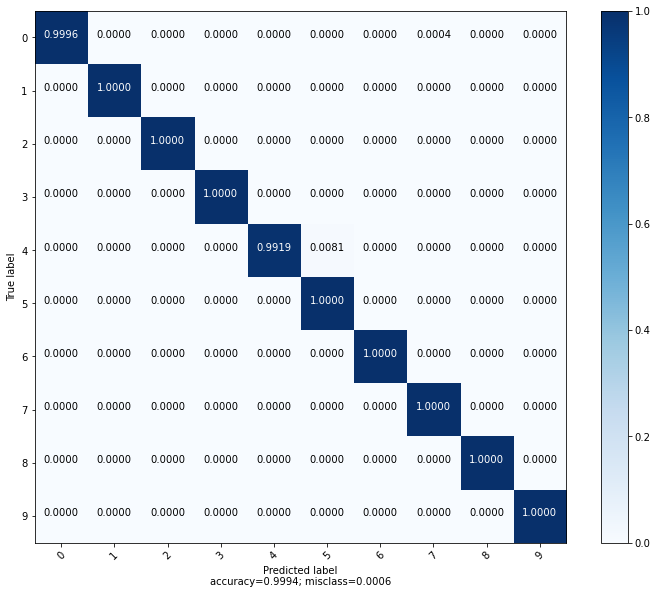

In [42]:

cm=matrix
normalize=True
target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


import matplotlib.pyplot as plt
import numpy as np
import itertools
cmap=None

accuracy = np.trace(cm) / float(np.sum(cm))
misclass = 1 - accuracy

if cmap is None:
    cmap = plt.get_cmap('Blues')

plt.figure(figsize=(10, 8))
plt.imshow(cm_normalized, interpolation='nearest', cmap=cmap)
#plt.title(title)
plt.colorbar()

if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    


thresh = cm.max() / 1.5 if normalize else cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if normalize:
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    else:
        plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")


plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('plots/conf_matrix4.png' , bbox_inches='tight')
plt.show()

In [43]:
model.save("models/digit_recognition_model9994.h5")

5
4


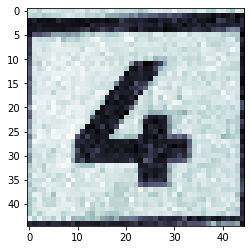

7
0


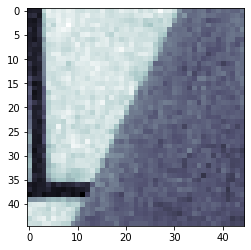

2


In [44]:
k=0
cell_size=45
true=[]
predicted=[]
j=0
gr_t=1
grid=[]
lst_index=[]
for i in range(0, len(y_pred)):
    if y_pred[i]!= yy_lab[i]:
        k=k+1
        lst_index.append(i)
        true.append(yy_lab[i])
        predicted.append(y_pred[i])
        #print(yy_lab[i])
        if j>80:
            gr_t=gr_t+1
            j=0
        grid.append(gr_t)
        
    
    j=j+1
        
        
        

failed=np.zeros((k, cell_size, cell_size), dtype=float)

for i in range(0, len(lst_index)):
    img=x_test[lst_index[i], :, :, 0]
    failed[i, :, :]=img
    #true.append(yy_lab[lst_index[i]])
    #predicted.append(y_pred[lst_index[i]])


num_img=4
n, m=int(np.sqrt(num_img)), int(np.sqrt(num_img))


#f = plt.figure(figsize=(11,11))
for i in range(0, k):
    #f.add_subplot(n,m, i)
    #plt.imshow(failed[i, :, :], cmap='bone')
    print(predicted[i])
    print(true[i])
    plt.imshow(failed[i, :, :], cmap='bone')
    plt.show()
    #tt='pred: '+str(predicted[i])
    #tt='true: '+str(true[i])+' pred: '+str(predicted[i])
    #plt.title(tt,fontsize=12)
    #plt.axis('off')

    
#plt.imshow(failed[i, :, :], cmap='bone')
#plt.savefig('plots/failed_digits2.png' , bbox_inches='tight')
#plt.show()
print(k)

### Just for Fun: Variational autoencoder
<br>
<br>

In [121]:

list_of_font=glob.glob('font2/*.ttf')
#xx, yy=create_data(30000, list_of_font, False)
X_train, y_train=create_data(40000, list_of_font, False)
#X_train, X_test, y_train, y_test = train_test_split(xx, yy, test_size=0.33, random_state=42)

In [122]:
yy_lab=np.load(y_test_path)
y_test=np.array(yy_lab)
x_test=np.load(x_test_path)
print(len(x_test))
print(np.shape(x_test))

3483
(3483, 45, 45, 1)


In [123]:
#x_train=xx
#y_train=yy

y_test2=y_test.copy()
num_classes=10
x_train=X_train
#x_test=X_test
print(np.shape(x_train))
x_train=np.expand_dims(x_train, axis=-1)
print(np.shape(x_train))

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(len(y_test))
print(len(x_test))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255

#x_test=x_test[:, :, :, 0]


(40000, 45, 45)
(40000, 45, 45, 1)
3483
3483


In [61]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))



tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[45, 45]),
    tf.keras.layers.Dense(100, activation="selu"),
    tf.keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="selu", input_shape=[30]),
    tf.keras.layers.Dense(45 * 45, activation="sigmoid"),
    tf.keras.layers.Reshape([45, 45])
])
stacked_ae = tf.keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=tf.keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, epochs=100,
                         validation_data=(x_test, x_test))



Epoch 1/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5601 - rounded_accuracy: 0.9197 - val_loss: 0.5940 - val_rounded_accuracy: 0.8817
Epoch 2/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5478 - rounded_accuracy: 0.9288 - val_loss: 0.5662 - val_rounded_accuracy: 0.8875
Epoch 3/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5421 - rounded_accuracy: 0.9333 - val_loss: 0.5688 - val_rounded_accuracy: 0.8925
Epoch 4/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5389 - rounded_accuracy: 0.9358 - val_loss: 0.5559 - val_rounded_accuracy: 0.9080
Epoch 5/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5359 - rounded_accuracy: 0.9382 - val_loss: 0.5658 - val_rounded_accuracy: 0.9029
Epoch 6/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5338 - rounded_accuracy: 0.9399 - val_loss: 0.5545 - val_rounded_accuracy: 0.9127
Epoch 7/100
1250/1250 [===========

1250/1250 [==============================] - 2s 1ms/step - loss: 0.5225 - rounded_accuracy: 0.9524 - val_loss: 0.5410 - val_rounded_accuracy: 0.9257
Epoch 52/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5224 - rounded_accuracy: 0.9524 - val_loss: 0.5424 - val_rounded_accuracy: 0.9295
Epoch 53/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5224 - rounded_accuracy: 0.9524 - val_loss: 0.5423 - val_rounded_accuracy: 0.9225
Epoch 54/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5223 - rounded_accuracy: 0.9525 - val_loss: 0.5410 - val_rounded_accuracy: 0.9280
Epoch 55/100
1250/1250 [==============================] - 2s 1ms/step - loss: 0.5223 - rounded_accuracy: 0.9525 - val_loss: 0.5422 - val_rounded_accuracy: 0.9235
Epoch 56/100
1250/1250 [==============================] - 2s 2ms/step - loss: 0.5223 - rounded_accuracy: 0.9526 - val_loss: 0.5427 - val_rounded_accuracy: 0.9221
Epoch 57/100
1250/1250 [=================

In [62]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(x_test)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

In [63]:
np.shape(X_valid_2D)
print(np.shape(y_test))

(3483, 10)


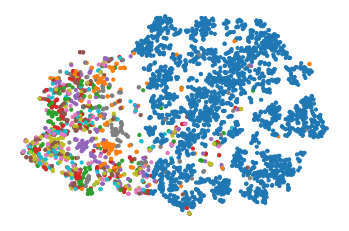

In [64]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_test2, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [124]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy


def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


image_size=45
input_shape = (image_size, image_size, 1)
#input_shape = (image_size, image_size)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
use_mse = True
load_weights = False


In [147]:

model = Sequential()
model.add(Conv2D(32, (4, 4), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 45, 45, 32)        544       
_________________________________________________________________
activation_19 (Activation)   (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 45, 45, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 45, 45, 32)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 22, 22, 64)      

In [125]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=3,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 45, 45, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 15, 15, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 5, 5, 64)     18496       conv2d_31[0][0]                  
__________________________________________________________________________________________________
flatten_16 (Flatten)            (None, 1600)         0           conv2d_32[0][0]                  
____________________________________________________________________________________________

In [126]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=3,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_34 (Dense)             (None, 1600)              4800      
_________________________________________________________________
reshape_9 (Reshape)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 45, 45, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 45, 45, 1)         289       
Total params: 60,481
Trainable params: 60,481
Non-trainable params: 0
_______________________________________________________

In [128]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [129]:
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [130]:
vae.compile(optimizer='rmsprop')
#vae.summary()

In [131]:
x_test=x_test[:, :, :, 0]

if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    #vae.save_weights('vae_cnn.h5')

Epoch 1/30
1250/1250 [==============================] - 7s 6ms/step - loss: 48.0713 - val_loss: 64.8501
Epoch 2/30
1250/1250 [==============================] - 4s 3ms/step - loss: 41.8736 - val_loss: 65.4733
Epoch 3/30
1250/1250 [==============================] - 4s 3ms/step - loss: 39.6198 - val_loss: 64.2298
Epoch 4/30
1250/1250 [==============================] - 4s 3ms/step - loss: 38.7853 - val_loss: 64.8858
Epoch 5/30
1250/1250 [==============================] - 4s 3ms/step - loss: 38.1358 - val_loss: 65.1510
Epoch 6/30
1250/1250 [==============================] - 4s 3ms/step - loss: 37.6224 - val_loss: 65.5499
Epoch 7/30
1250/1250 [==============================] - 4s 3ms/step - loss: 37.2384 - val_loss: 63.9562
Epoch 8/30
1250/1250 [==============================] - 4s 3ms/step - loss: 36.9666 - val_loss: 66.5082
Epoch 9/30
1250/1250 [==============================] - 4s 3ms/step - loss: 36.7782 - val_loss: 65.4666
Epoch 10/30
1250/1250 [==============================] - 4s 3ms/

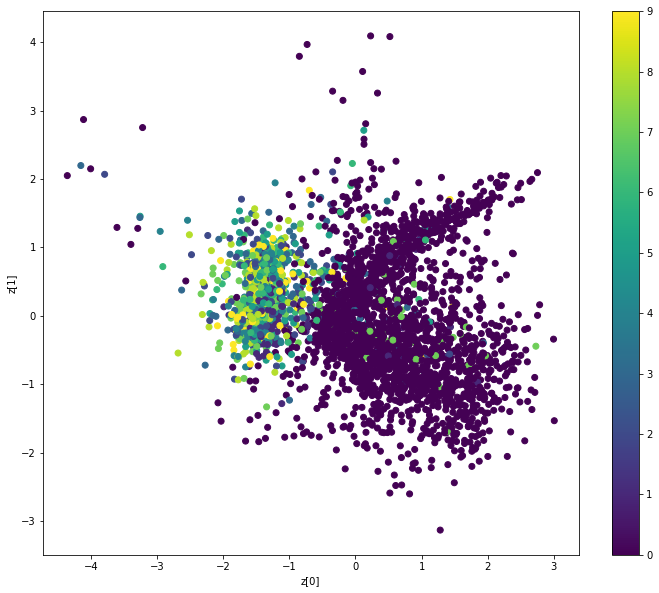

ValueError: cannot reshape array of size 2025 into shape (28,28)

In [135]:
plot_results(encoder, decoder, x_test, y_test2, batch_size=batch_size)

In [134]:
y_test2

array([0, 0, 0, ..., 0, 0, 0])

### Mnist Test:
<br>
<br>


In [87]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
#import argparse
import os


In [88]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
# Only get some data to train and test
train_len = 10000
test_len = 1000
x_train = np.reshape(x_train[:train_len], [-1, image_size, image_size, 1])
x_test = np.reshape(x_test[:test_len], [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_test = y_test[:test_len]

y_train[20] =  4
y_train[500] =  3
y_train[3000] =  9
y_train[9000] =  6


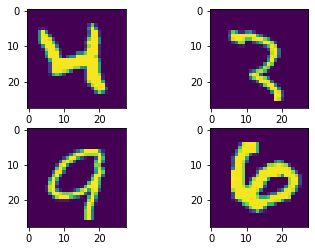

In [89]:
x_train_show = x_train.reshape(-1,28,28)
plt.figure(1)
plt.subplot(221)
plt.imshow(x_train_show[20])
print('y_train[20] = ', y_train[20])

plt.subplot(222)
plt.imshow(x_train_show[500])
print('y_train[500] = ', y_train[500])

plt.subplot(223)
plt.imshow(x_train_show[3000])
print('y_train[3000] = ', y_train[3000])

plt.subplot(224)
plt.imshow(x_train_show[9000])
print('y_train[9000] = ', y_train[9000])
plt.show()

In [90]:
# reparameterization trick: instead of sampling from Q(z|X), sample epsilon = N(0,1)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def plot_results(encoder, decoder, x_test, y_test, batch_size=128):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.show()



In [91]:
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
use_mse = True
load_weights = False

In [92]:
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 7, 7, 64)     18496       conv2d_12[0][0]                  
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 3136)         0           conv2d_13[0][0]                  
____________________________________________________________________________________________

In [93]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 2)]               0         
_________________________________________________________________
dense_25 (Dense)             (None, 3136)              9408      
_________________________________________________________________
reshape_7 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [94]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [95]:
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


In [96]:
vae.compile(optimizer='rmsprop')
vae.summary()


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 69076       encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 28, 28, 1)    65089       encoder[1][2]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 14, 14, 32)   320         encoder_input[0][0]              
________________________________________________________________________________________________

In [97]:
if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    #vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/30
313/313 [==============================] - 14s 44ms/step - loss: 54.4025 - val_loss: 47.1240
Epoch 2/30
313/313 [==============================] - 1s 3ms/step - loss: 45.3968 - val_loss: 44.2095
Epoch 3/30
313/313 [==============================] - 1s 3ms/step - loss: 44.0204 - val_loss: 42.8714
Epoch 4/30
313/313 [==============================] - 1s 3ms/step - loss: 43.2757 - val_loss: 42.7609
Epoch 5/30
313/313 [==============================] - 1s 3ms/step - loss: 42.7602 - val_loss: 42.5924
Epoch 6/30
313/313 [==============================] - 1s 3ms/step - loss: 42.3176 - val_loss: 42.3344
Epoch 7/30
313/313 [==============================] - 1s 3ms/step - loss: 41.8780 - val_loss: 41.7579
Epoch 8/30
313/313 [==============================] - 1s 3ms/step - loss: 41.4695 - val_loss: 42.4217
Epoch 9/30
313/313 [==============================] - 1s 3ms/step - loss: 41.0779 - val_loss: 41.5885
Epoch 10/30
313/313 [==============================] - 1s 3ms/step - loss: 40.72

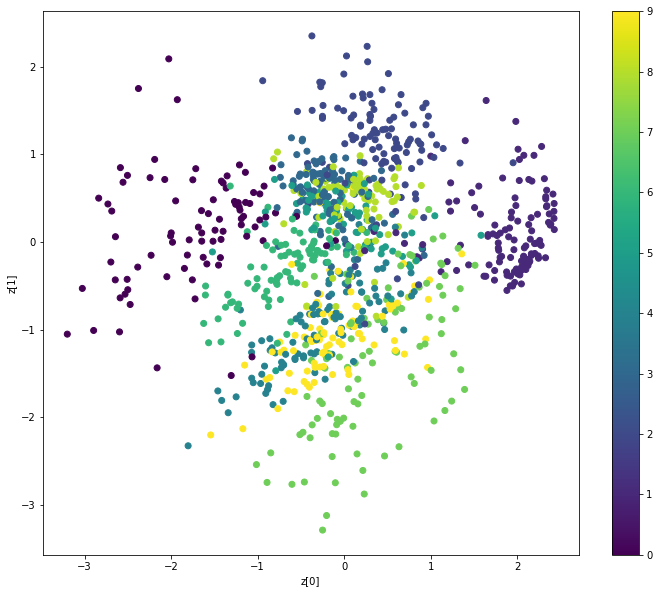

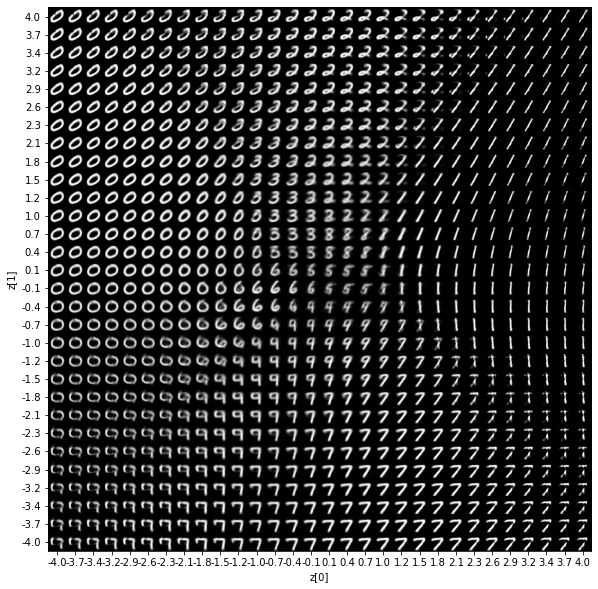

In [98]:
plot_results(encoder, decoder, x_test, y_test, batch_size=batch_size)

In [143]:
input_shape

(2025,)

In [145]:

from tensorflow.keras.layers import Conv2D, Activation, Dense, Lambda, Input, MaxPooling2D, Dropout, Flatten, Reshape, UpSampling2D, Concatenate

image_shape = (45, 45, 1)
original_dim = image_shape[0] * image_shape[1]
input_shape = (original_dim,)
batch_size = 128
latent_dim = 4
epochs = 20

# encoder
inputs = Input(shape=input_shape)
x = Reshape(image_shape)(inputs)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
label_inputs = Input(shape=(10,), name='label')
x = Concatenate()([latent_inputs, label_inputs])
x = Dense(128, activation='relu')(x)
x = Dense(22 * 22 * 32, activation='relu')(x)
x = Reshape((22, 22, 32))(x)
x = Dropout(0.25)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
outputs = Reshape(input_shape)(x)

decoder = Model([latent_inputs, label_inputs], outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# variational autoencoder
outputs = decoder([encoder(inputs)[2], label_inputs])
vae = Model([inputs, label_inputs], outputs, name='vae_mlp')
vae.summary()
#plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 2025)]       0                                            
__________________________________________________________________________________________________
reshape_19 (Reshape)            (None, 45, 45, 1)    0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 45, 45, 32)   320         reshape_19[0][0]                 
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 45, 45, 32)   9248        conv2d_59[0][0]                  
____________________________________________________________________________________________